## Introduction

Diabetes is a chronic condition in which the body either does not produce enough insulin or cannot use it effectively, leading to elevated levels of glucose in the blood. Over time, this imbalance can result in serious complications affecting various organs and systems, including the heart, kidneys, eyes, and nerves. According to the World Health Organization (WHO), more than 420 million people worldwide live with diabetes—a number that continues to rise. Despite its widespread impact, public awareness remains limited, and many individuals are unaware they have the condition until significant symptoms or complications appear.

In this project, the use of probabilistic graphical models—specifically Bayesian belief networks—is investigated as a tool to assist healthcare professionals in the diagnosis of Diabetes and to promote greater awareness of the disease in the general population. A Bayesian network has been developed, integrating key risk factors and typical symptoms related to diabetes.


The dataset used was obtained from tricca.com and consists of n rows and m columns. Each row represents a patient's medical record containing the following information:

**Diabete:** 
- 0: no diabetes
- 1: prediabetes or diabetes

**HighBP (Hight Blood Pressure):**
- 0: no high BP
- 1: high BP

**HighCol (High colesterol):**
- 0: no high colesterol
- 1: high colesterol

**BMI:**
- 0: underweight  
- 1: normal weight 
- 2: overweight  
- 3: obese 

**Age:**
- 0: 18<=age<=35
- 1: 36<=age<=64
- 2: 65<=age<=80
- 3: age>81 

**Stroke:**
- 0: no
- 1: yes

**HeartDiseasorAttack (coronary heart disease (CHD) or myocardial infarction (MI)):**
- 0: no
- 1: yes 

**Smoker:**
- 0: no
- 1: yes

**PhysActivity (physical activity in past 30 days - not including job):**
- 0: no
- 1: yes 

## Data preprocessing

In [5]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import networkx as nx
from pgmpy.estimators import BicScore,K2Score
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pgmpy")

In [6]:
# Import the dataset

df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df = df.drop(columns=["Income", "Education","Sex","DiffWalk","CholCheck", "HvyAlcoholConsump", "GenHlth", "AnyHealthcare", "NoDocbcCost", "Fruits", "Veggies", "PhysHlth", "MentHlth"]).reset_index(drop=True)
df.rename(columns={'Diabetes_012': 'Diabetes'}, inplace=True)

print(f"The are {df.shape[0]} samples and {df.shape[1]} features")
df.head(10)

The are 253680 samples and 9 features


,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Age
0,0.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,9.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,7.0
2,0.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,9.0
3,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,11.0
4,0.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,11.0
5,0.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,10.0
6,0.0,1.0,0.0,30.0,1.0,0.0,0.0,0.0,9.0
7,0.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,11.0
8,2.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,9.0
9,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,8.0


In [7]:
print("Diabetes values distirbution:")
df["Diabetes"].value_counts()

Diabetes values distirbution:


Diabetes
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

As we can see, the dataset contains a very small number of observations with diabetes = 1 compared to the other classes. Therefore, we decided to merge classes 1 and 2 into a single category representing patients with either "prediabetes" or "diabetes".
Moreover we can see that the distribution of our dataset is unbalanced, so we decided to reduce the number of samples where Diabetes = 0.0, using the imported function **RandomUnderSampler**

In [8]:
# Let's prepare the data for the Sampler

X = df.drop(columns=["Diabetes"])  
y = df["Diabetes"]

# Instantiate the Sampler
under_sampler = RandomUnderSampler(sampling_strategy={0.0: 40000}, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df["Diabetes"] = y_resampled.replace({2.0: 1.0})

print(df["Diabetes"].value_counts())


Diabetes
0.0    40000
1.0    39977
Name: count, dtype: int64


In [9]:
# Let's see if there are some missing values
df.isna().sum()

HighBP                  0
HighChol                0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Age                     0
Diabetes                0
dtype: int64

Now, we need to encode the variables Age and BMI, since, as we can see:

In [10]:
unique_series = df.apply(lambda x: x.unique())
print(f"{unique_series} \n")
print(f"Range of values of BMI: {df['BMI'].min()} - {df['BMI'].max()}")
print(f"Range of values of Age: {df['Age'].min()} - {df['Age'].max()}")

HighBP                                                         [0.0, 1.0]
HighChol                                                       [0.0, 1.0]
BMI                     [24.0, 32.0, 28.0, 35.0, 27.0, 43.0, 47.0, 34....
Smoker                                                         [0.0, 1.0]
Stroke                                                         [0.0, 1.0]
HeartDiseaseorAttack                                           [0.0, 1.0]
PhysActivity                                                   [0.0, 1.0]
Age                     [9.0, 8.0, 6.0, 4.0, 7.0, 11.0, 3.0, 1.0, 10.0...
Diabetes                                                       [0.0, 1.0]
dtype: object 

Range of values of BMI: 12.0 - 98.0
Range of values of Age: 1.0 - 13.0


age and BMI are the only continuous variables in our dataset.

In [11]:
# ENCODING OF AGE AND BMI

# Age
#   - 1<=Age<=4: 0 and means between 18 and 35
#   - 5<=Age<=9: 1 and means beatwee 36 and 64
#   - 10<=Age<=17: 2 and means between 65 and 80
#   - 18=Age: 3 and means 81 or older

binning_rules = {
    "BMI": {
        "bins": [12, 17, 27, 44, 98],
        "labels": [0, 1, 2, 3]
    },
    "Age": {
        "bins": [1, 4, 9, 17, 18],
        "labels": [0, 1, 2, 3]
    }
}

for col, rule in binning_rules.items():
    df[col] = pd.cut(df[col], bins=rule["bins"], labels=rule["labels"], include_lowest=True).astype(int)

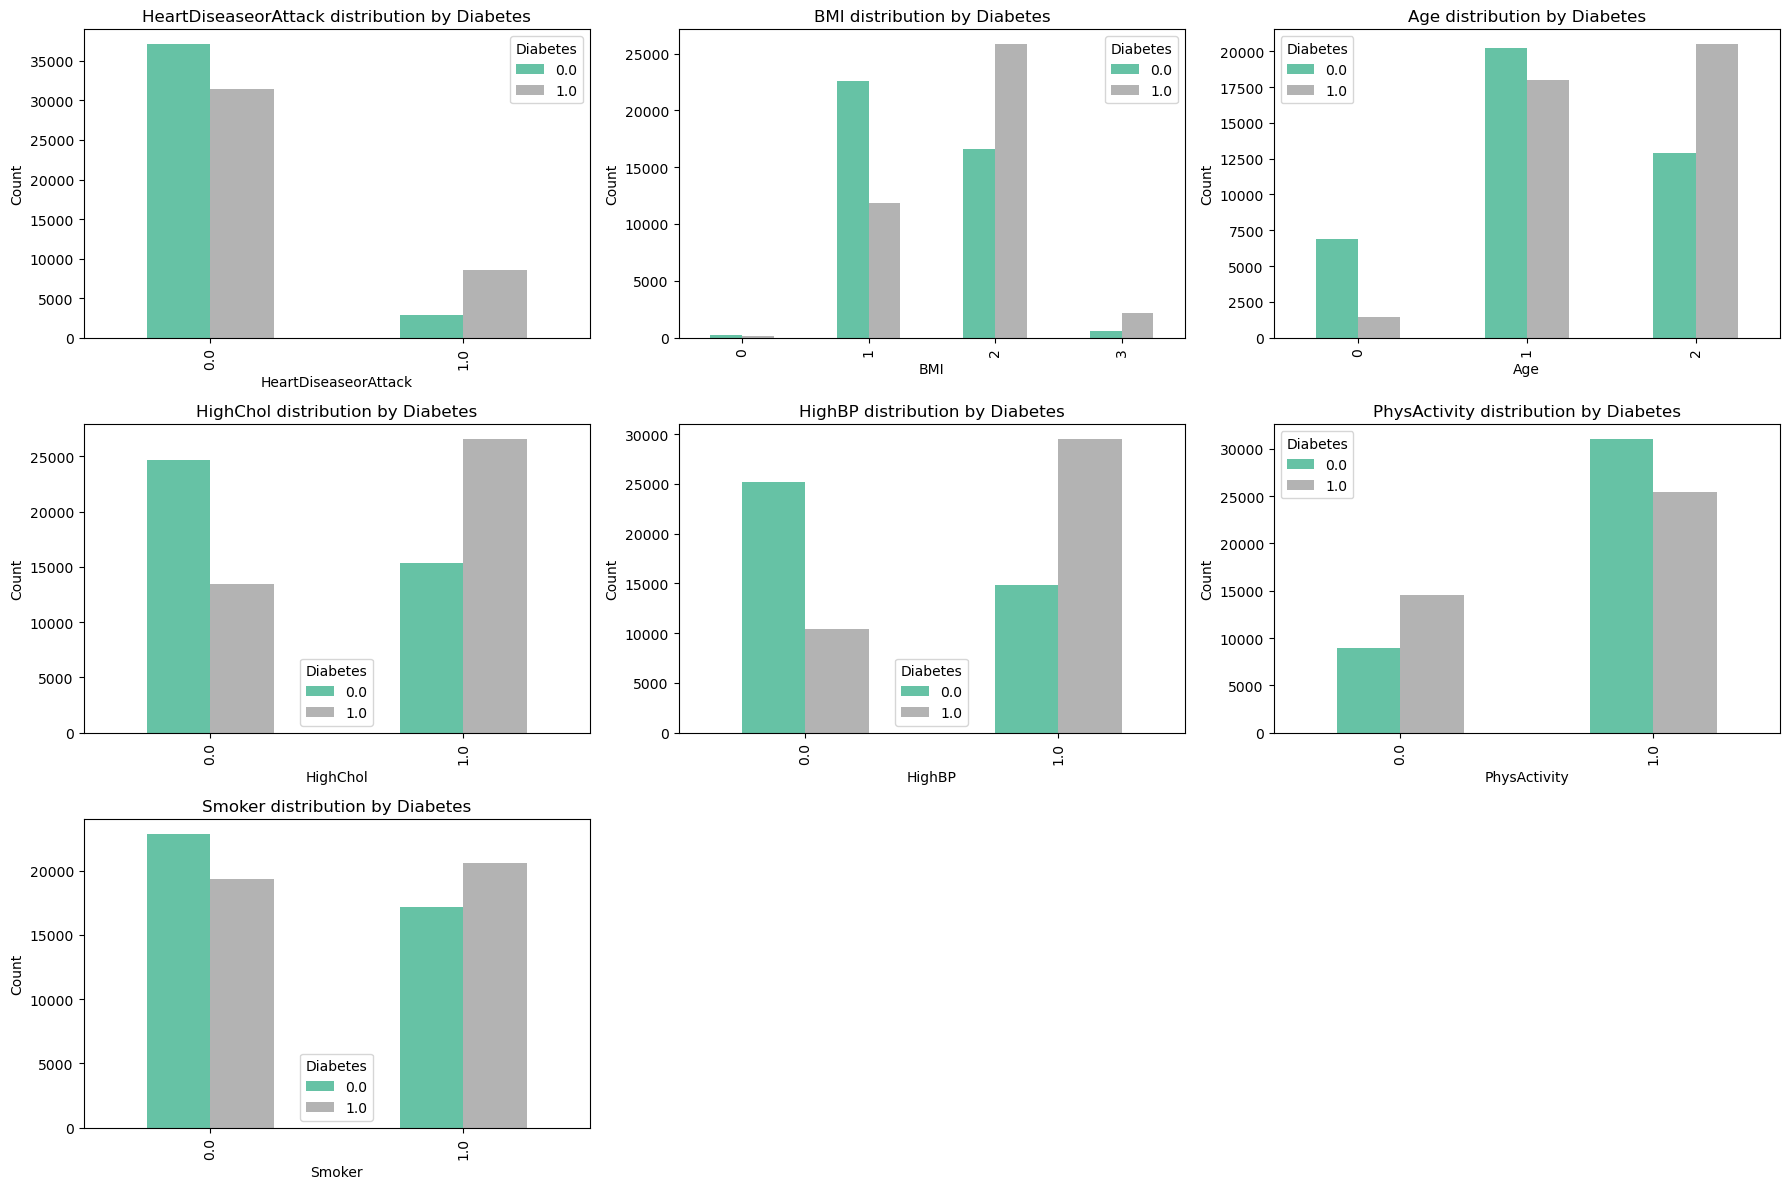

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Lista delle variabili esplicative
features = ['HeartDiseaseorAttack', 'BMI', 'Age', 'HighChol', 'HighBP', "PhysActivity","Smoker"]

# Imposta il layout dei subplot (3 righe x 3 colonne)
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))  # 6 feature -> lasceremo uno vuoto

# Flatten per indicizzazione semplice degli assi
axes = axes.flatten()

# Loop sulle feature e subplot
for idx, feature in enumerate(features):
    ax = axes[idx]
    
    # Crea tabella di contingenza
    crosstab = pd.crosstab(df[feature], df['Diabetes'])

    # Plot non impilato (side-by-side)
    crosstab.plot(kind='bar', stacked=False, ax=ax, colormap='Set2')
    
    ax.set_title(f'{feature} distribution by Diabetes')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='Diabetes')

# Rimuovi subplot vuoti (se ci sono meno di 9 feature)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

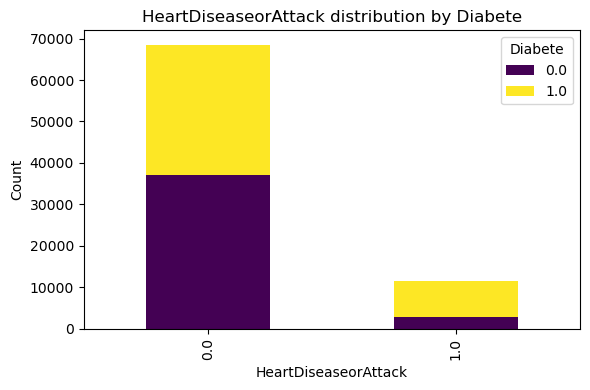

<Figure size 600x400 with 0 Axes>

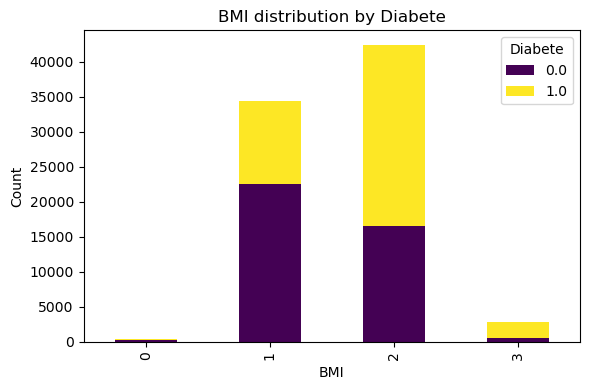

<Figure size 600x400 with 0 Axes>

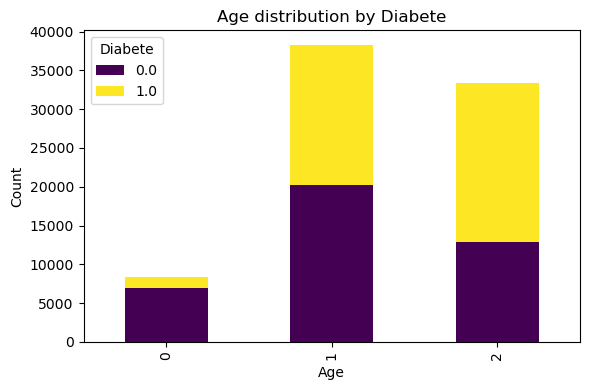

<Figure size 600x400 with 0 Axes>

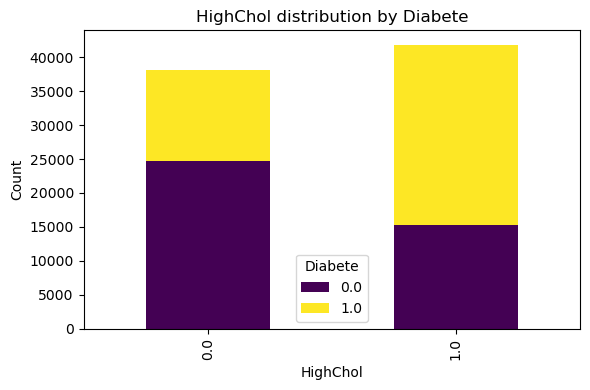

<Figure size 600x400 with 0 Axes>

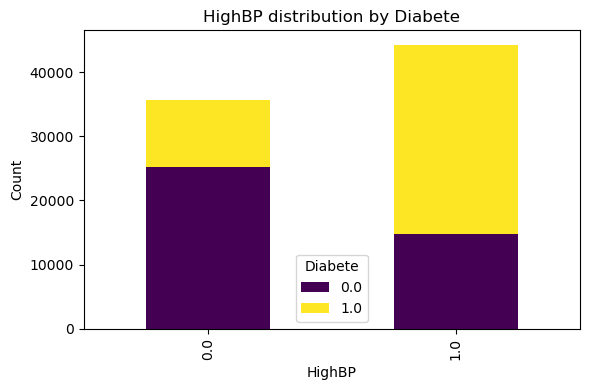

<Figure size 600x400 with 0 Axes>

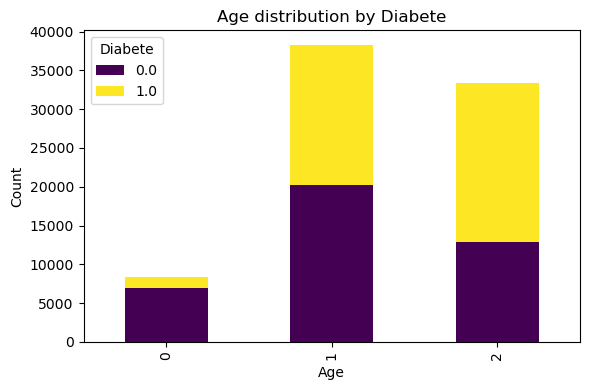

<Figure size 600x400 with 0 Axes>

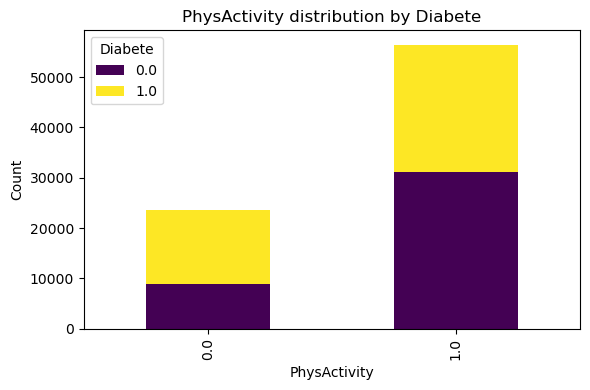

In [13]:
import matplotlib.pyplot as plt

# Lista delle variabili esplicative
features = ['HeartDiseaseorAttack', 'BMI', 'Age', 'HighChol', 'HighBP', "Age", "PhysActivity"]

# Ciclo per plottare gli istogrammi
for feature in features:
    plt.figure(figsize=(6, 4))
    # Crea una tabella di contingenza
    crosstab = pd.crosstab(df[feature], df['Diabetes'])
    crosstab.plot(kind='bar', stacked=True, colormap='viridis', figsize=(6, 4))
    
    plt.title(f'{feature} distribution by Diabete')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Diabete')
    plt.tight_layout()
    plt.show()

## Network Structure

The next step was to define the structure of our Bayesian network.

1) In the first approach, we manually constructed the network by adding meaningful edges based on domain knowledge and the semantic relationships between the explanatory variables and our target variable, **diabetes**.

2) We then explored a data-driven approach using pgmpy's **HillClimbSearch** function. This method employs a greedy search algorithm that starts from an empty network (or a predefined one) and iteratively adds or removes edges to maximize a scoring function. In our case, we used the **Bayesian Information Criterion (BIC)** as the scoring metric, which balances model fit and complexity by considering both the likelihood of the data and the simplicity of the network.

In [14]:
# Function to plot efficiently the network

def plot_bayesian_network(model):
    nx_graph = nx.DiGraph(model.edges())
    pos = nx.spring_layout(nx_graph, k=0.55, seed=42)
    plt.figure(figsize=(10, 10))
    nx.draw(nx_graph, pos, with_labels=True, node_color="skyblue",
            node_size=2000, font_size=8, edge_color="black", font_weight="bold",
            arrowsize=8, linewidths=2)

    plt.title("Bayesian Network", fontsize=14)
    plt.show()

In [15]:
# Define the Bayesian Network
semantic_model = BayesianModel([('HighBP', 'Diabetes'), 
                       ('HighChol', 'Diabetes'),
                       ('BMI', 'Diabetes'),
                       ('BMI', 'HighBP'),                       
                       ('BMI', 'HighChol'),
                       ('Diabetes', 'Stroke'),                       
                       ('Diabetes', 'HeartDiseaseorAttack'),
                       ('Age', 'Diabetes'),
                       ('Age', 'HighBP'),
                       ('Age', 'HeartDiseaseorAttack'),
                       ('PhysActivity', 'HighBP'),   
                       ('Smoker', 'HeartDiseaseorAttack'),   
                                          
                       ])

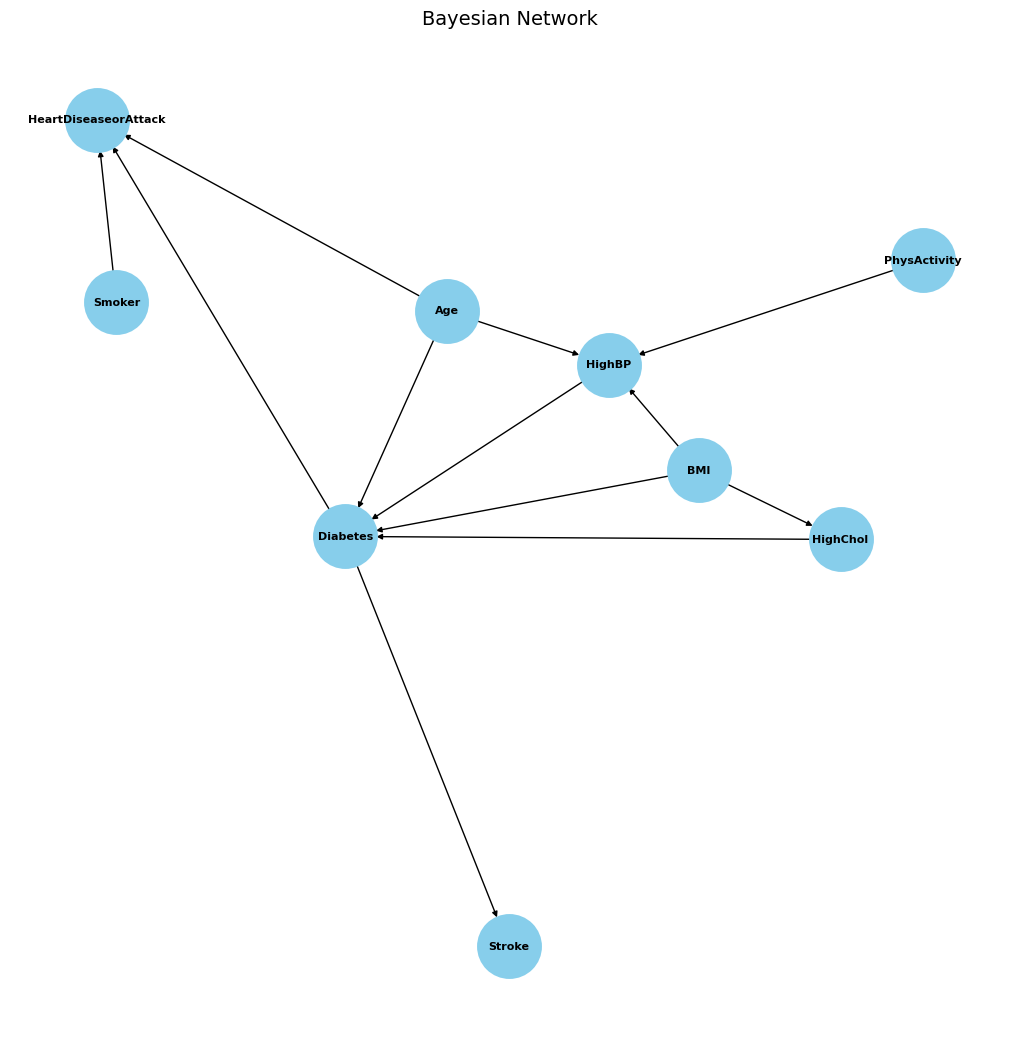

In [16]:
plot_bayesian_network(semantic_model)

In [17]:
# Run the Hill Climbing search and create the model

hc = HillClimbSearch(df)
hc_model= hc.estimate(scoring_method="bicscore" )

  0%|          | 0/1000000 [00:00<?, ?it/s]

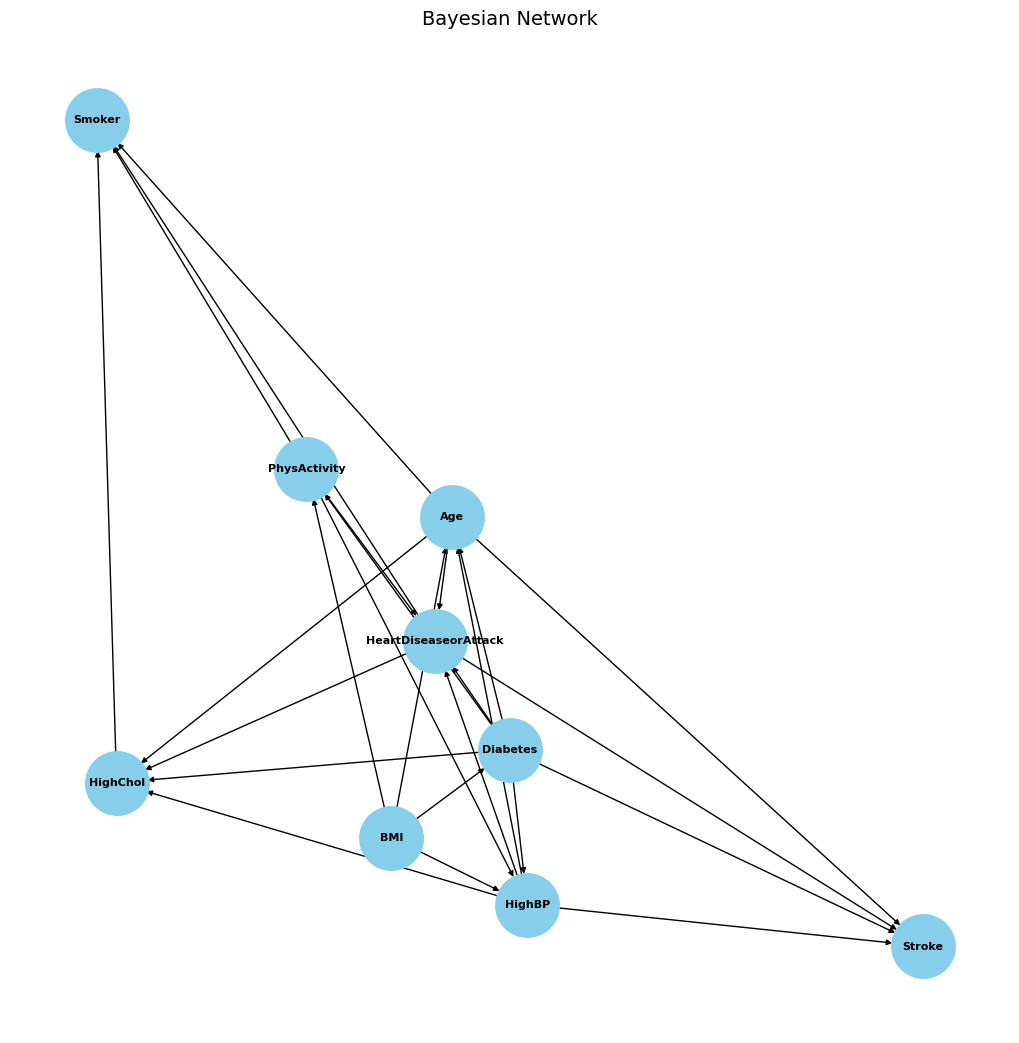

In [18]:
plot_bayesian_network(hc_model)

Between the two networks created, we chose to proceed with the analysis using the manually defined network. The structure learned through HillClimbSearch resulted in some cause-effect relationships that lacked semantic or domain-specific validity.

For example the edge **BMI** --> **Age** is meaningless because the variable **Age** can only act as a cause within the network, not as an effect. This is because a person's age is determined just by the passage of time and cannot be influenced by any of the other variables in the dataset. Allowing other variables to "cause" age would violate the temporal and logical consistency of the model. 

This makes the manually constructed network more suitable for our purposes.

## Learning parameters

The next step is to fit the model to our data using the .fit function provided by pgmpy. This allows us to add the parameters to our network, enabling us to visualize and work with the Conditional Probability Tables (CPTs). By doing so, we can begin to understand how probabilities are distributed across the variables and identify which factors have the greatest influence within the network.



In [19]:
# Fit the data to the Bayesian Network to obtain the CPTs
semantic_model.fit(df)

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup


# Print all the learned CPTs
for cpd in semantic_model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print_full(cpd)
    print('\n')


CPT of HighBP
+--------------+-------------------+---------------------+--------------------+---------------------+--------------------+--------------------+-------------------+--------------------+---------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+---------------------+--------------------+--------------------+---------------------+---------------------+--------------------+---------------------+
| Age          | Age(0)            | Age(0)              | Age(0)             | Age(0)              | Age(0)             | Age(0)             | Age(0)            | Age(0)             | Age(1)              | Age(1)             | Age(1)             | Age(1)              | Age(1)             | Age(1)             | Age(1)              | Age(1)             | Age(2)              | Age(2)              | Age(2)             | Age(2)             | Age(2)         

As we can see, the CPTs display reasonable probability values.

For instance, and quite intuitively, we can observe that the probability of having **HighCol** increases as **BMI** increases.

Aumentare



## Exact inference

Now, since the network is relatively small, we can take advantage of exact inference to answer some useful and interesting questions in the medical field.
We will do this using the bla bla bla function, with the bla bla bla heuristic.

The first case we examined is a bla bla bla case.

Vedere bene metodi e parametri di variable elimination

Qual è la probabilitá per una persona anziana con con alto livello di colesterolo di avere il diabete?

Quale è la probabilitá di un fumatore in sovrappeso con diabete di avere un infarto?

Qual è la probabilitá per una persona con diabete di avere entrambi i valori di colesterolo e Blood pressure alti?

In [20]:
inference = VariableElimination(semantic_model)
prob_diabetes = inference.query(
    variables=["Diabetes"], 
    evidence={"Age": 2, "HighChol":1}, 
    show_progress=True,
    )
print(prob_diabetes)

+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(0.0) |          0.3275 |
+---------------+-----------------+
| Diabetes(1.0) |          0.6725 |
+---------------+-----------------+


In [21]:
# Quale è la probabilitá di per un fumatore in sovrappeso di avere un infarto?
prob_heart_disease = inference.query(variables=["HeartDiseaseorAttack"], evidence={"BMI": 3, "Smoker":1})
# Quale è la probabilitá di per un non fumatore in sovrappeso di avere un infarto?
prob_heart_disease2 = inference.query(variables=["HeartDiseaseorAttack"], evidence={"BMI": 3, "Smoker":0})

print(prob_heart_disease)
print("\n")
print(prob_heart_disease2)


+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+===========================+=============================+
| HeartDiseaseorAttack(0.0) |                      0.7862 |
+---------------------------+-----------------------------+
| HeartDiseaseorAttack(1.0) |                      0.2138 |
+---------------------------+-----------------------------+


+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+===========================+=============================+
| HeartDiseaseorAttack(0.0) |                      0.8642 |
+---------------------------+-----------------------------+
| HeartDiseaseorAttack(1.0) |                      0.1358 |
+---------------------------+-----------------------------+


In [22]:

# Quale è la probabilitá di per una persona in sovrappeso con diabete di avere un infarto?
BMIvalues= sorted(df["BMI"].unique())
for i in BMIvalues:
    print(f"BMI = {i} :")
    prob_heart_disease = inference.query(variables=["HeartDiseaseorAttack"], evidence={"BMI": 2, "Diabetes":1, "Smoker":1})
    print(prob_heart_disease)
    print("\n")


BMI = 0 :
+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+===========================+=============================+
| HeartDiseaseorAttack(0.0) |                      0.7474 |
+---------------------------+-----------------------------+
| HeartDiseaseorAttack(1.0) |                      0.2526 |
+---------------------------+-----------------------------+


BMI = 1 :
+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+===========================+=============================+
| HeartDiseaseorAttack(0.0) |                      0.7474 |
+---------------------------+-----------------------------+
| HeartDiseaseorAttack(1.0) |                      0.2526 |
+---------------------------+-----------------------------+


BMI = 2 :
+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+=====

In [23]:
#Qual è la probabilitá per una persona con diabete di avere entrambi i valori di colesterolo e Blood pressure alti?
prob_diabetes2 = inference.query(variables=["HighChol", "HighBP"], evidence={"Diabetes":1})
print(prob_diabetes2)

+---------------+-------------+------------------------+
| HighChol      | HighBP      |   phi(HighChol,HighBP) |
+===============+=============+========================+
| HighChol(0.0) | HighBP(0.0) |                 0.1016 |
+---------------+-------------+------------------------+
| HighChol(0.0) | HighBP(1.0) |                 0.2838 |
+---------------+-------------+------------------------+
| HighChol(1.0) | HighBP(0.0) |                 0.1825 |
+---------------+-------------+------------------------+
| HighChol(1.0) | HighBP(1.0) |                 0.4321 |
+---------------+-------------+------------------------+


Approximate inference
With rejection sampling

In [24]:
from pgmpy.sampling import BayesianModelSampling

# Inizializza il campionatore
sampler = BayesianModelSampling(semantic_model)

# Rejection Sampling: genera campioni condizionati sull'evidenza
samples = sampler.rejection_sample(evidence=[State(var="Age",state=2), State(var="HighChol", state =1)], size = 1000)
# Calcola la distribuzione P(HighChol, HighBP | Diabetes=1)
result = samples[["Diabetes"]].value_counts(normalize=True)

print(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

Diabetes
1.0         0.667
0.0         0.333
Name: proportion, dtype: float64


In [25]:
sampler = BayesianModelSampling(semantic_model)

# Rejection Sampling: genera campioni condizionati sull'evidenza
samples = sampler.rejection_sample(evidence=[State(var="Diabetes",state=1)], size = 1000)
# Calcola la distribuzione P(HighChol, HighBP | Diabetes=1)
result = samples[["HighChol", "HighBP"]].value_counts(normalize=True)

print(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

HighChol  HighBP
1.0       1.0       0.398
0.0       1.0       0.306
1.0       0.0       0.183
0.0       0.0       0.113
Name: proportion, dtype: float64


Likelihood weighting

In [26]:
# Inizializza il campionatore
sampler = BayesianModelSampling(semantic_model)

# Rejection Sampling: genera campioni condizionati sull'evidenza
samples = sampler.likelihood_weighted_sample(evidence=[State(var="Age",state=2), State(var="HighChol", state =1)], size = 1000)
# Calcola la distribuzione P(HighChol, HighBP | Diabetes=1)
result = samples[["Diabetes"]].value_counts(normalize=True)

print(result)

  0%|          | 0/9 [00:00<?, ?it/s]

Diabetes
1.0         0.659
0.0         0.341
Name: proportion, dtype: float64


In [27]:
sampler = BayesianModelSampling(semantic_model)

# Rejection Sampling: genera campioni condizionati sull'evidenza
samples = sampler.likelihood_weighted_sample(evidence=[State(var="Diabetes",state=1)], size = 1000)
# Calcola la distribuzione P(HighChol, HighBP | Diabetes=1)
result = samples[["HighChol", "HighBP"]].value_counts(normalize=True)

print(result)

  0%|          | 0/9 [00:00<?, ?it/s]

HighChol  HighBP
1.0       1.0       0.292
0.0       1.0       0.276
          0.0       0.222
1.0       0.0       0.210
Name: proportion, dtype: float64
